# Data Science in Business. Determination of the most profitable oil production region

The purpose of this work is determination the most profitable oil region using machine learning and bootstrap.

On assignment, oil samples were provided in three regions. Each region has 10,000 samples, which measured the quality of oil and the volume of reserves. It is required to build a model that will determine the region with the highest profit with risk constraint

Process of hole choosing:

- There are three regions and we have information about 10,000  holes for each region. We make model for each region that predict reserves for each concrete hole probe.
- We try 500 new holes and predict oil reserves for each of them using pre-trained models in the previous paragraph
- Based on the results of predictions, we select 200 out of 500 and start developing them
- How much it was possible to get, so much earned
- We must determinate the most profitable oil production region where 500 holes will be trying. In the selected region the probability of losses must be less than 2.5%.

In [1]:
from typing import Tuple, List
import os
from tqdm import tqdm_notebook
import multiprocessing as mp
import numpy as np
from numpy.random import RandomState
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Data loading and preprocessing

Columns description
- `id` — unique ID
- `f0`, `f1`, `f2` — some features
- `product` — oil reserve in thousand of barrels

In [3]:
data_0 = pd.read_csv('datasets/geo_data_0.csv')
data_1 = pd.read_csv('datasets/geo_data_1.csv')
data_2 = pd.read_csv('datasets/geo_data_2.csv')

data_0.info()
data_1.info()
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [4]:
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

In [5]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [7]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Resume**
- data loaded
- there are no passes and outliers
- id column was dropped
- mean product values for `region 0` and `2` higher than for `region 1`

## Modeling

In [8]:
RANDOM_STATE = 137

In [9]:
# model training and generating predictions
def oil_model(data):
    data_f = data.drop(['product'], axis=1)
    data_t = data['product']
    train_f, valid_f, train_t, valid_t = train_test_split(data_f, data_t, train_size=0.75, random_state=RANDOM_STATE)

    # we use LR because it model is suitable in our case
    model = LinearRegression()
    model.fit(train_f, train_t)

    valid_f = valid_f.reset_index(drop=True)
    valid_t = valid_t.reset_index(drop=True)

    df = pd.DataFrame()
    df['product'] = valid_t
    df['predicted'] = model.predict(valid_f)
    
    return df

In [10]:
# metrics calculation
def get_metrics(df):
    return [mean_squared_error(df['product'], df['predicted'], squared=False),\
            df['predicted'].mean(),\
            df['product'].std(),\
            df['product'].mean()]

In [11]:
# save all to df
df = []
stat = pd.DataFrame(columns=['rmse', 'predicted_mean', 'product_std', 'product_mean'])

df.append(oil_model(data_0))
stat.loc['Region 0'] = get_metrics(df[0])

df.append(oil_model(data_1))
stat.loc['Region 1'] = get_metrics(df[1])

df.append(oil_model(data_2))
stat.loc['Region 2'] = get_metrics(df[2])

stat.style.format("{:,.2f}")

,rmse,predicted_mean,product_std,product_mean
Region 0,37.79,92.44,44.42,92.24
Region 1,0.89,69.06,45.93,69.07
Region 2,40.12,95.09,44.73,94.62


**Resume**
- all models are trained
- for r`egions 0 `and `2` (that have higher mean values) we have less accurate models. However for `region 1` we have more accurate model
- more accurate model can help us to select more profitable 200 holes in 500 probes

## Profit and Risk Calculation

In [34]:
BUDGET = 10e9  
HOLES_COUNT = 200
SAMPLES_COUNT = 500
PRICE = 450e3
BOOTSTRAP_COUNT = 1000

Let us calculate the sufficient volume of raw materials for the break-even development of a new hole.

In [13]:
print('Average sufficient reserve in the hole for break-even production =', BUDGET/HOLES_COUNT/PRICE)

Average sufficient reserve in the hole for break-even production = 111.11111111111111


Compare the received volume of raw materials with the average stock in each region

In [14]:
stat['product_mean']

Region 0    92.238651
Region 1    69.065290
Region 2    94.618927
Name: product_mean, dtype: float64

So, average stock in each region is less than average sufficient reserve in the hole for break-even production. Therefore we must use predictions and risk analyst

**Profit and Risk Calculation**

We will use Pandas sampling for bootstrap because we don't have a lot of data and we need to sample exactly SAMPLES_COUNT holes. In big data Poisson Bootstrap is preferable because it's more faster.

In [37]:
def calc_profit(products):
    return products.sum() * PRICE - BUDGET

In [38]:
state = RandomState(RANDOM_STATE) 
profits = pd.DataFrame(columns=['region_0', 'region_1', 'region_2'])

for i in range(BOOTSTRAP_COUNT):
    
    profit_by_region = []
    for region in range(3):
        samples = df[region].sample(SAMPLES_COUNT, random_state=state)
        holes = samples.sort_values('predicted', ascending=False).head(HOLES_COUNT)
        profit = calc_profit(holes['product'])
        profit_by_region.append(profit)
      
    profits = profits.append({'region_0':profit_by_region[0], 'region_1':profit_by_region[1], 
                              'region_2':profit_by_region[2]}, ignore_index=True)
    
profits.head()

,region_0,region_1,region_2
0,3.546994e+08,6.760416e+08,3.650766e+08
1,3.800487e+08,1.816151e+08,3.808578e+08
2,5.069041e+08,4.162951e+08,-2.007662e+08
3,5.129528e+08,4.727103e+08,3.469460e+08
4,2.350900e+08,4.727103e+08,1.763777e+08


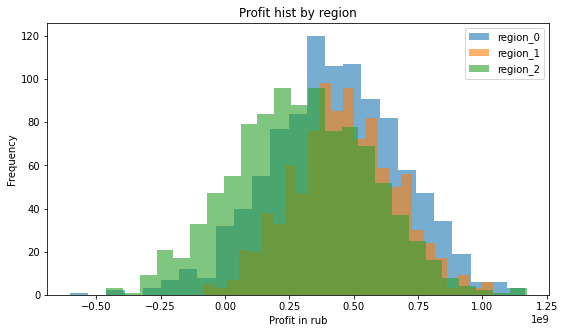

In [39]:
ax = profits['region_0'].plot(kind='hist', bins=25, alpha=0.6, legend=True, \
                              title='Profit hist by region', figsize=(9,5), xlabel='Profit, rub')
ax = profits['region_1'].plot(kind='hist', bins=25, ax=ax, alpha=0.6, legend=True)
ax = profits['region_2'].plot(kind='hist', bins=25, ax=ax, alpha=0.6, legend=True)
ax.set_xlabel("Profit in rub");

In [44]:
class Quantile:
    def __init__(self, q):
        self.q = q
        
    def __call__(self, x):
        return x.quantile(self.q)

class OilLoss:
    def __call__(self, x):
        return 100.0 * (x<0).mean()


In [45]:
x = (profits / 1e6).agg(['mean', Quantile(0.025), Quantile(0.975), OilLoss()]).transpose()
x.columns = ['profit mean', 'profit Q=0.025', 'profit Q=0.975', 'losses percent']
x.style.format("{:,.2f}")

,profit mean,profit Q=0.025,profit Q=0.975,losses percent
region_0,427.11,-90.08,903.55,4.40
region_1,462.84,76.65,849.39,0.80
region_2,300.00,-223.71,820.01,13.30


### Resume
- Profit and risk analysis is made for earch region.
- Region 1 has greatest profit and least losses because it region has madel with better prediction quality

## Conclusion

**Prepared and tested model**
- a prediction model has been prepared for each region
- for each region, data were prepared with a comparison of predicted values ​​and true values ​​for the validation sample
- note that for "Region 1" the model predicts quite accurately. But for the other two, it is quite wrong. Comparison with models on a different structure concluded that in these regions the data are poorly predictable and this is a feature of the problem

**Preliminary calculation of profit has been made**
- the average reserve in wells is less than the average reserve for break-even production
- thus, the right choice is said to be a very important process
- note that in "region 1" the average stock is much less, but the prediction is much more accurate
- written and tested profit calculation function

**Profit and risk analysis performed**
- for each region, the average revenue, the confidence interval of revenue, and the probability of unprofitable development are determined
- region 1 turned out to be profitable due to good predictability (if you do not do a stat analysis, then the average production in it is the lowest, and in the most unprofitable one, on the contrary, the average production is the highest)

**Recommend area for development**
<br>
Region 1 is preferred for development:
- the risks are much less than others
- average profit is higher than others